# Intertidal Digital Elevation Model

**What does this notebook do?** This notebook uses the ITEM 2.0 product to compute continuous elevation data for Australia's intertidal zone. It initially imports ITEM OFFSET files and median tidal elevations for each tidal interval, computes elevations at interval boundaries, extracts contours around each tidal interval, and then interpolates between these contours using TIN/Delaunay triangulation linear interpolation. This interpolation method preserves the tidal interval boundaries of ITEM 2.0. The notebook exports the contours used for interpolation as line shapefiles and the resulting DEM as a geotiff, and finally performs a simple validation using RTK GPS data.

**Date:** March 2018

**Author:** Robbi Bishop-Taylor

## Load modules and define functions

In [23]:
# Import libraries
import sys
import os
import glob
import fiona
import itertools
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import statsmodels.formula.api as sm
from collections import OrderedDict
from shapely.geometry import Point, LineString, MultiLineString, mapping
from fiona.crs import from_epsg
from osgeo import gdal
from scipy.interpolate import griddata
from scipy import ndimage as nd
from skimage import measure
from matplotlib import pyplot as plt

# Import DEA Notebooks scripts
sys.path.append(os.path.abspath('/g/data/r78/rt1527/dea-notebooks/algorithms'))
from DEADataHandling import array_to_geotiff

"""
TODO: Investigate scipy.interpolate.RectBivariateSpline, scipy.interpolate.interp2d,
spipy.interpolate.RegularGridInterpolator, sklearn.gaussian_process.GaussianProcess
"""

def fill(data, invalid=None):
    """
    Replace value of invalid cells by the value of the nearest 
    cell with valid data

    :attr data: numpy array of any dimension
    :attr invalid: a binary array of same shape as 'data'. Data value 
                   are replaced where invalid is True. Defaults to 
                   np.isnan(data) if no layer is given

    :returns: Array with invalid values filled with nearest valid data value
    """    
    
    # If no invalid array is given, default to setting invalid based on nan
    if invalid is None:
        
        invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, 
                                    return_distances=False, 
                                    return_indices=True)
    
    return data[tuple(ind)]


## Set up analysis
Set up path to data and polygon to process. `plotting_subset` does not affect the analysis, but can be used to provide more useful zoomed-in plots.

In [40]:
# Working directory
os.chdir("/g/data/r78/rt1527/item_dem")

# Path to ITEM offset product
item_offset_path = "/g/data2/v10/ITEM/offset_products"

# Set ITEM polygon for analysis
polygon_ID = 143

# Zoom-in for plots (has no effect on analysis but allows you to plot a zoomed-in subset)
# plotting_subset = np.index_exp[:, :]
plotting_subset = np.index_exp[1750: 1950, 930:1130]

# Print run details
print("Processing polygon {0} from {1}".format(polygon_ID, item_offset_path))

Processing polygon 143 from /g/data2/v10/ITEM/offset_products


## ITEM interval boundary value extraction
ITEM offset values represent the median tidal height for each tidal interval ([Sagar et al. 2015](https://doi.org/10.1016/j.rse.2017.04.009)). Because ITEM tidal intervals are linearly spaced by design, this code uses a simple linear model to extract new offset values for each interval boundary (e.g. the boundary between ITEM interval 1 and 2). This allows us to assign a more appropriate tidal height to the contours that divide the ITEM tidal intervals than would be possible through simply assigning median tidal heights to the downhill or uphill contours. 

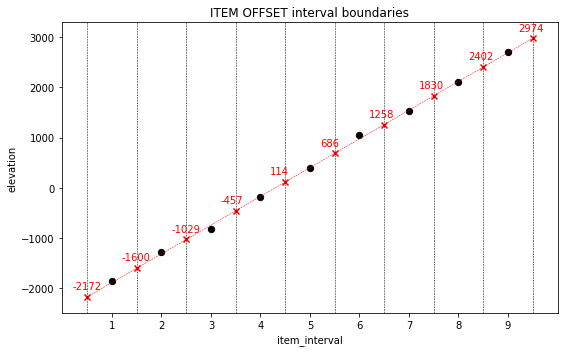

In [41]:
# Import ITEM elevation classes
item_offsets = np.loadtxt("{}/elevation.txt".format(item_offset_path), delimiter = ",", dtype = "str")
item_offsets = {int(key):[int(val) for val in value.split(" ")] for (key, value) in item_offsets}
interval_offsets = item_offsets[polygon_ID]

# Create dataframe
df = pd.DataFrame({"item_interval": range(1,10),
                   "elevation": interval_offsets})

# Compute linear model and calculate 
m, b = np.polyfit(df["item_interval"], df["elevation"], 1)
interval_boundaries = np.arange(0.5, 10.5, 1.0)
contour_offsets = (m * interval_boundaries + b).astype(int)

# Plot output
fig, ax = plt.subplots(figsize=(8,5))
df.plot(kind = "scatter", x = "item_interval", y = "elevation", s = 40, color = "black", 
        xticks=df['item_interval'], ax = ax)
ax.scatter(interval_boundaries, contour_offsets, color = 'red', marker = "x")
ax.plot(interval_boundaries, contour_offsets, color = 'red', linestyle = '--', lw = 0.5)
for xc in interval_boundaries:
    plt.axvline(x=xc, color='k', linestyle='--', lw = 0.5)
for i, txt in enumerate(contour_offsets):
    ax.annotate(txt, (interval_boundaries[i] - 0.3, contour_offsets[i] + 150), color = "red")
plt.title("ITEM OFFSET interval boundaries")
plt.tight_layout()


## Import and prepare ITEM OFFSET
Imports ITEM OFFSET raster for given polygon, and prepares by removing nodata and adding in artificially low minimum interval to ensure correct contour extraction.

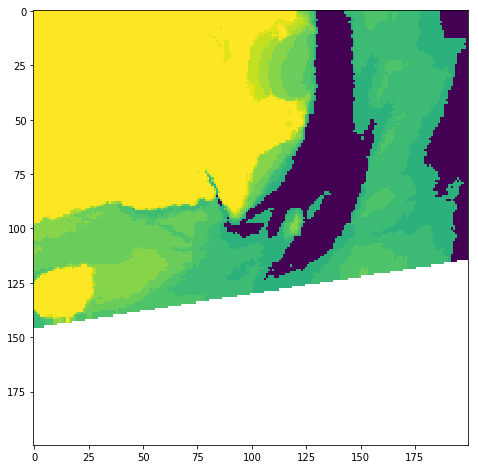

In [42]:
# Import raster and extract shape, projection info and geotransform data
filename = glob.glob("{0}/ITEM_OFFSET_{1}_*.tif".format(item_offset_path, polygon_ID))[0]
src_ds = gdal.Open(filename)
srcarray = src_ds.GetRasterBand(1).ReadAsArray() 
yrows, xcols = srcarray.shape
prj = src_ds.GetProjection()
geotrans = src_ds.GetGeoTransform()
upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans

# Copy original data so array can be modified 
item_array = np.copy(srcarray)

# Set nodata to NaN, and force 0 values to a low negative  (-9999) to allow correct 
# contour extraction (i.e. make "0" data sit beneath the lowest ITEM tidal stage)
item_array[item_array == -6666] = np.nan
item_array[item_array == 0] = -9999

# Dilate data area of array by two pixels to eliminate NA contours on tile edges
# (this only affects pixels directly on the boundary of two polygon arrays)
dilated_array = nd.morphology.binary_dilation(~np.isnan(item_array),  iterations=2)
item_array = fill(item_array)
item_array[~dilated_array] = np.nan

# Plot original data
plt.figure(figsize = (8, 8))
plt.imshow(item_array[plotting_subset])  
plt.show()


## Extract contours
Uses `scikit.measure.find_contours` to rapidly extract contour boundaries between ITEM tidal intervals, and assigns these contours with previously calculated elevation values. Contours are exported as line shapefiles to assist in subsequent assessment of output DEMs.

In [43]:
# Output dict to hold contours for each offset
contour_dict = OrderedDict()

try:
    for contour_offset in contour_offsets:

        # Extract contours from array
        contours = measure.find_contours(item_array, contour_offset)      
        print("Extracting contour {}".format(contour_offset))
        
        # Iterate through each contour feature, remove NAs and fix coordinates
        contour_list = list()
        for contour in contours:

            # Convert index coordinates to spatial coordinates in-place
            contour[:,0] = contour[:,0] * float(y_size) + upleft_y + (float(y_size) / 2)
            contour[:,1] = contour[:,1] * float(x_size) + upleft_x + (float(x_size) / 2)        
            contour = np.insert(contour, 2, contour_offset, axis = 1)

            # Remove contour points with NAs
            contour = contour[~np.isnan(contour).any(axis=1)] 
            contour_list.append(contour)

        # Add list of contour arrays to dict 
        contour_dict[contour_offset] = contour_list
except:
    print("fail")

    
# Export contours to line shapefile to assist in evaluating DEMs
schema = {'geometry':  'MultiLineString', 
          'properties': { 'elevation': 'int' } }      

with fiona.open("output_data/ITEM_DEM_{}_lines.shp".format(polygon_ID), "w", 
                crs = from_epsg(3577),
                driver = "ESRI Shapefile", 
                schema = schema) as output:
    
    for elevation_value, contour_list in contour_dict.items():
        
        # Filter out contours with less than two points (i.e. non-lines)
        contour_list = [x for x in contour_list if len(x) > 1]
        
        # Create multiline string by first flipping coordinates then creating list of linestrings
        contour_linestrings = [LineString([(x, y) for (y, x, z) in contour_array]) 
                               for contour_array in contour_list]
        contour_multilinestring = MultiLineString(contour_linestrings)

        # Write output shapefile to file with elevation field        
        output.write({'properties': { 'elevation': int(elevation_value) },
                      'geometry': mapping(contour_multilinestring) })
        
# Chain and concatenate all arrays nested within array lists (i.e. individual collections of same 
# elevation contours) and dictionary entries (i.e. collections of all same-elevation contours)
alldata = np.concatenate(list(itertools.chain.from_iterable(contour_dict.values())))
points = alldata[:,0:2]
values = alldata[:,2]


Extracting contour -2172
Extracting contour -1600
Extracting contour -1029
Extracting contour -457
Extracting contour 114
Extracting contour 686
Extracting contour 1258
Extracting contour 1830
Extracting contour 2402
Extracting contour 2974


## Interpolate contours using TIN/Delaunay triangulation interpolation
Exports a DEM by interpolating previously extracted contours. This uses the linear method from `scipy.interpolate.griddata`, which computes a TIN/Delaunay triangulation of the input data using Qhull before performing linear barycentric interpolation on each triangle.

Interpolating data for polygon 143


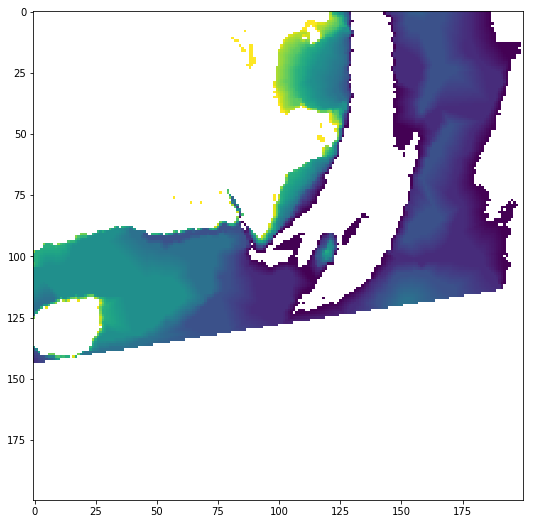

Exporting DEM for polygon 143


In [44]:
# Extract bounds of ITEM layer
minx = upleft_x
maxx = upleft_x + (x_size * xcols)
miny = upleft_y + (y_size * yrows)
maxy = upleft_y

# Create interpolation grid (from, to, by in metres)
grid_y, grid_x = np.mgrid[maxy:miny:1j * yrows,
                          minx:maxx:1j * xcols]

# Interpolate between points onto grid. This uses the 'linear' method from 
# scipy.interpolate.griddata, which computes a TIN/Delaunay triangulation of the input 
# data with Qhull and performs linear barycentric interpolation on each triangle
print("Interpolating data for polygon {}".format(polygon_ID))
interpolated_array = griddata(points, values, (grid_y, grid_x), method = "linear")

# Mask out NaNs, zero values and max tidal stage from original ITEM offset layer
gooddata_mask = ((srcarray != -6666) & (srcarray != 0) & (srcarray != interval_offsets[8]))
interpolated_array[~gooddata_mask] = np.nan

# Plot
plt.figure(figsize = (9, 9))
plt.imshow(interpolated_array[plotting_subset])
plt.show()

# Export resulting DEM as a geotif
print("Exporting DEM for polygon {}".format(polygon_ID))
array_to_geotiff(fname = "output_data/ITEM_DEM_{}.tif".format(polygon_ID), 
                 data = interpolated_array, 
                 geo_transform = geotrans, 
                 projection = prj, 
                 nodata_val = np.nan)


## Validation
Test the resulting DEM by comparing against RTK GPS field-recorded data. Because validation data only exists for polygon 33 (Darwin), this imports DEM data for polygon 33 if another polygon is being analysed.

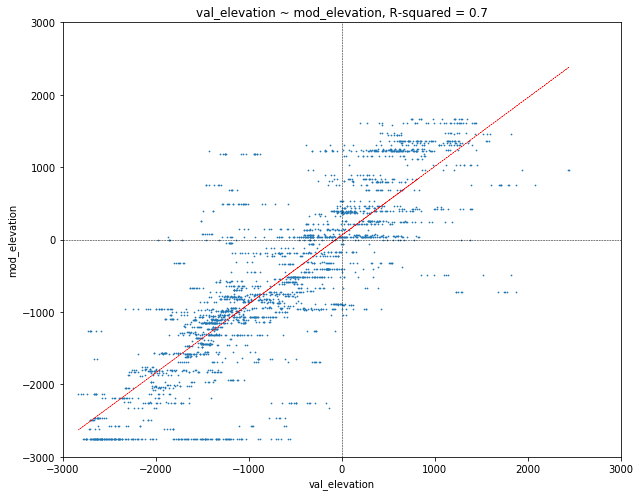

In [14]:
# Because validation data only exists for polygon 33, use this data to compare to validation values
if polygon_ID != 33:
    
    # Import polygon 33 from file
    print("Importing ITEM_DEM_33.tif from file")
    poly33_ds = gdal.Open(glob.glob("output_data/ITEM_DEM_33.tif")[0])
    interpolated_array = poly33_ds.GetRasterBand(1).ReadAsArray() 
    
    # Get projection
    geotrans = poly33_ds.GetGeoTransform()
    upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans  
    

# Open validation point shapefile and use to extract data from underlying array
with fiona.open('raw_data/EastPointonlyRTK_albers.shp') as points:

    point_output = list()

    for n, point in enumerate(points):

        # Extract data from shapefile points; fix units by multiplying by 1000
        x, y = point["geometry"]["coordinates"]
        val_elev = point["properties"]["field_4"] * 1000.0

        # Convert geographic coordinates into index coordinates
        x_ind = int((x - upleft_x) / x_size) # x pixel
        y_ind = int((y - upleft_y) / y_size) # y pixel 

        # Extract modelled elevation from DEM array
        mod_elev = interpolated_array[y_ind, x_ind]

        # Append to list
        point_output.append([x, y, val_elev, mod_elev])

# Combine into dataframe    
colnames = ["x", "y", "val_elevation", "mod_elevation"]
modval_elev = pd.DataFrame(point_output, columns = colnames).dropna() 
modval_elev = modval_elev[modval_elev['val_elevation'] < 2500]

# Compute linear model
m, b = np.polyfit(modval_elev["val_elevation"], modval_elev["mod_elevation"], 1)
modval_rsquared = sm.ols(formula = "val_elevation~mod_elevation", data = modval_elev).fit().rsquared

# Plot output x-y scatter plot
fig, ax = plt.subplots(figsize = (9, 7))
modval_elev.plot(x = "val_elevation", 
                 y = "mod_elevation", 
                 kind = "scatter", 
                 s = 0.5, ax = ax)
ax.plot(modval_elev["val_elevation"], m * modval_elev["val_elevation"] + b, 
        color = 'red', linestyle = '--', lw = 0.5)
plt.axvline(x = 0, color = 'k', linestyle = '--', lw = 0.5)
plt.axhline(y = 0, color = 'k', linestyle = '--', lw = 0.5)
ax.set_ylim(-3000, 3000)
ax.set_xlim(-3000, 3000)
plt.title("val_elevation ~ mod_elevation, R-squared = {}".format(np.round(modval_rsquared, 3)))
plt.tight_layout()


## Lidar validation

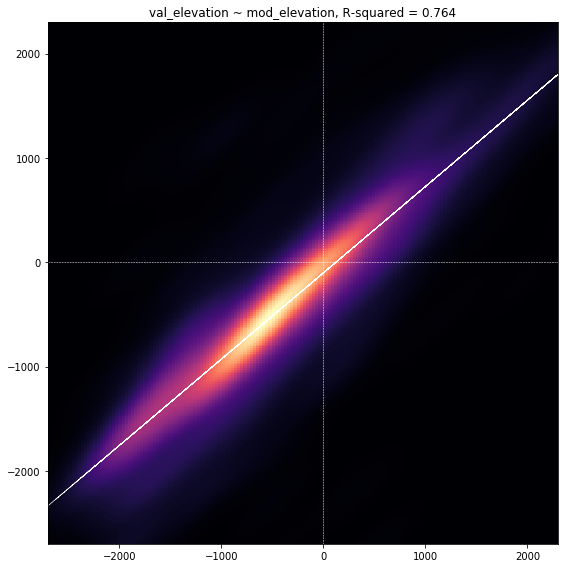

In [85]:
import osr
from ShapefileTools import rasterize_vector
from pyproj import Proj, transform
from matplotlib import cm
from scipy.stats import kde
from matplotlib.colors import LogNorm

def wkt_to_proj4(prj):

    inSRS_converter = osr.SpatialReference()  # makes an empty spatial ref object
    inSRS_converter.ImportFromWkt(prj)  # populates the spatial ref object with our WKT SRS
    inSRS_forPyProj = inSRS_converter.ExportToProj4()
    
    return(inSRS_forPyProj)

# Set up dict of pairs of polygon IDs and Lidar validation datasets to iterate over
validation_dict = {'273': '/g/data/r78/rt1527/NT/z53/ntz53.tif',
                   '47': '/g/data/r78/rt1527/NT/z53/ntz53.tif',
                   '33': '/g/data/r78/rt1527/NT/z52/ntz52.tif',
#                    '300': '/g/data/r78/rt1527/QLD/z56/tiles/qldz56_60000_60000.tif',
                   '143': '/g/data/r78/rt1527/QLD/z56/tiles/qldz56_0_0.tif'}

# # Output list
# output_list = []

# for polygon_ID, validation_path in validation_dict.items():
    
#     print(polygon_ID, validation_path)

#     # Import Intertidal DEM data
#     idem_ds = gdal.Open(glob.glob("output_data/ITEM_DEM_{}.tif".format(polygon_ID))[0])
#     idem_array = idem_ds.GetRasterBand(1).ReadAsArray() 
#     idem_rows, idem_cols = idem_array.shape
#     idem_prj = idem_ds.GetProjection()
#     idem_geotrans = idem_ds.GetGeoTransform()
#     idem_upleft_x, idem_x_size, _, idem_upleft_y, _, idem_y_size = idem_geotrans

#     # Import LIDAR data
#     lidar_ds = gdal.Open(glob.glob(validation_path)[0])
#     lidar_array = lidar_ds.GetRasterBand(1).ReadAsArray() 
#     lidar_rows, lidar_cols = lidar_array.shape
#     lidar_prj = lidar_ds.GetProjection()
#     lidar_geotrans = lidar_ds.GetGeoTransform()
#     lidar_upleft_x, lidar_x_size, _, lidar_upleft_y, _, lidar_y_size = lidar_geotrans  

#     # Rasterize polygon of intertidal LIDAR areas
#     poly_array = rasterize_vector(input_data = "validation_data/lidar_intertidal_proj_{}.shp".format(polygon_ID), 
#                                  cols = lidar_cols, 
#                                  rows = lidar_rows, 
#                                  geo_transform = lidar_geotrans,
#                                  projection = lidar_prj, 
#                                  field = "class")

#     # Take a random sample of cells that contain data
#     i, j = np.nonzero(poly_array)
#     ix = np.random.choice(len(i), np.floor(0.0010 * len(i)).astype('int'), replace=False)
#     ix_elev = (lidar_array[i[ix], j[ix]] * 1000).astype('int')

#     # Add into a dataframe
#     new_df = pd.DataFrame({'x': j[ix], 'y': i[ix], 'elev': ix_elev})
#     # new_df.plot(x ='x', y = 'y', kind  = 'scatter', s = 1, figsize = (8, 8)).invert_yaxis()

#     # Index coordinates to spatial coordinates 
#     new_df['y'] = new_df['y'] * float(lidar_y_size) + lidar_upleft_y + (float(lidar_y_size) / 2)
#     new_df['x'] = new_df['x'] * float(lidar_x_size) + lidar_upleft_x + (float(lidar_x_size) / 2) 

#     # Old spatial to new spatial
#     new_df['x'], new_df['y'] = transform(Proj(wkt_to_proj4(lidar_prj)), 
#                                          Proj(wkt_to_proj4(idem_prj)), 
#                                          new_df['x'].values,
#                                          new_df['y'].values)

#     # Now back to new indexes
#     x_ind = [int((xx - idem_upleft_x) / float(idem_x_size)) for xx in new_df['x']] # x pixel
#     y_ind = [int((yy - idem_upleft_y) / float(idem_y_size)) for yy in new_df['y']] # y pixel

#     # Add IDEM values to dataframe
#     new_df["elev_item"] = idem_array[y_ind, x_ind]

#     # Remove invalid values including nodata
#     new_df.loc[new_df.elev < -20000, 'elev'] = np.nan
#     new_df = new_df.dropna()
    
#     # Set polygon ID column and append to list    
#     new_df["polygon_ID"] = int(polygon_ID)
#     output_list.append(new_df)
    

# # Combine dataframes    
# new_df = pd.concat(output_list)  
        
# Compute linear model on validation vs modelled data
m, b = np.polyfit(new_df["elev"], new_df["elev_item"], 1)
modval_rsquared = sm.ols(formula = "elev~elev_item", data = new_df).fit().rsquared

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
x = new_df["elev"]
y = new_df["elev_item"]
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
zi = np.power(zi, 0.8)

# Plot output x-y scatter plot
fig, ax = plt.subplots(figsize = (8, 8))
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = "magma")

# new_df.plot(x = "elev", 
#             y = "elev_item", 
# #             c = "polygon_ID",
# #             cmap = "jet"
#             kind = "scatter", 
#             s = 1, 
#             ax = ax)

ax.plot(new_df["elev"], m * new_df["elev"] + b, 
        color = 'white', linestyle = '--', lw = 0.5) 
plt.axvline(x = 0, color = 'white', linestyle = '--', lw = 0.5)
plt.axhline(y = 0, color = 'white', linestyle = '--', lw = 0.5)
ax.set_ylim(-2700, 2300)
ax.set_xlim(-2700, 2300)
plt.title("val_elevation ~ mod_elevation, R-squared = {}".format(np.round(modval_rsquared, 3)))
plt.tight_layout()
# # # new_df.to_csv("validation_data/test_sample2.csv", sep = ",")


In [80]:
# np.exp(zi, 2)

np.power(zi, 0.9)

array([  1.35419658e-08,   1.49376614e-08,   1.65113440e-08, ...,
         1.31688813e-41,   2.83267901e-41,   5.98664634e-41])

(array([  1.40000000e+01,   2.90000000e+01,   4.10000000e+01,
          5.80000000e+01,   7.10000000e+01,   5.04000000e+02,
          4.97822400e+06,   3.83278600e+06,   9.64185600e+06,
          1.90169700e+06]),
 array([-8.40480042, -7.46436037, -6.52392033, -5.58348029, -4.64304025,
        -3.70260021, -2.76216017, -1.82172013, -0.88128009,  0.05915995,
         0.99959999]),
 <a list of 10 Patch objects>)

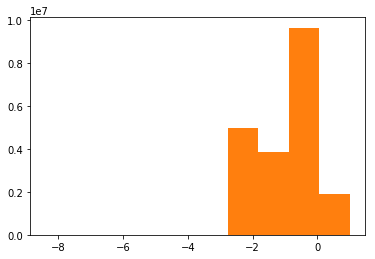

In [131]:
# lidar_data = lidar_array[i,j]
# lidar_data = lidar_data[lidar_data > -3.30282306e+38]
# lidar_data = lidar_data[lidar_data < 1]
# np.percentile(lidar_data, (0, 100))

# plt.hist(lidar_data, bins = 200)

lidar_test = lidar_array[(lidar_array > -3.30282306e+38) & (lidar_array < 1)]
hist_data = plt.hist(lidar_test, bins = 10)
plt.hist(lidar_test, bins = 10)


In [27]:
lidar_data

array([-0.49079999, -0.47920001, -0.49039999, ...,  2.60759997,
        2.47200012,  2.58520007], dtype=float32)

In [132]:
hist_data[1][np.argmax(hist_data[0])]

-0.88128008842468297

In [133]:
tf1 = np.insert(hist_data[0] > 6000000, 0, False)
tf2 = np.insert(hist_data[0] > 6000000, len(hist_data[0]), False)

In [134]:
hist_data[1][tf1]

array([ 0.05915995])

In [135]:
hist_data[1][tf2]

array([-0.88128009])

In [137]:
# plot_binary = ((lidar_array >= -0.88128009) & (lidar_array <= 0.05915995)).astype("float")
# plot_binary[lidar_array < -3.30282306e+38] = np.nan

# plt.figure(figsize=(10,10))
# plt.imshow(plot_binary[5000:10000, 5000:10000])
# plt.show()


array_to_geotiff("validation_data/test_hightide.tif", plot_binary, lidar_geotrans, lidar_prj)





In [85]:
lidar_test

array([-1.21000004, -1.23600006, -1.33000004, ...,  7.76599979,
        7.72000027,  7.63999987], dtype=float32)

In [101]:
plot_binary.shape

(13705, 17337)

## Lidar timepoints

In [202]:
from otps.predict_wrapper import predict_tide
from otps import TimePoint 
import datetime

def gps_to_epoch(gps_time):
    
    """
    Computes an approximate conversion between GPS time and UNIX epoch. 
    Does not account for leap seconds at this stage, as this level of accuracy 
    is not required for tidal modelling. 
    """
    
    unix_epoch = int(315964782 + (gps_time + 1000000000))
    
    return(unix_epoch)


# Compute GPS time
unix_epoch = gps_to_epoch(107199183.39387)
time1 = datetime.datetime.utcfromtimestamp(unix_epoch)
# time1 = datetime.datetime(2018, 3, 28, 2, 12)

# Extract location and combine into timepoint
lat, lon = -23.8719152963, 151.303472413
test_tp1 = TimePoint(lon, lat, time1)

# Process tidal data
output_tides = predict_tide([test_tp1])
print(output_tides[0].tide_m)


-0.816


In [ ]:
# Compute GPS time
unix_epoch = gps_to_epoch(107199183.39387)
time1 = [datetime.datetime.utcfromtimestamp(gps_to_epoch(t)) for t in list(range(107198183, 107199183, 60))]
# time1 = datetime.datetime(2018, 3, 28, 2, 12)

# Extract location and combine into timepoint
lat, lon = -23.8719152963, 151.303472413
test_tp1 = TimePoint(lon, lat, time1)

# Process tidal data
output_tides = predict_tide([test_tp1])
print(output_tides[0].tide_m)

In [204]:
list(range(107198183, 107199183, 60))

[107198183,
 107198243,
 107198303,
 107198363,
 107198423,
 107198483,
 107198543,
 107198603,
 107198663,
 107198723,
 107198783,
 107198843,
 107198903,
 107198963,
 107199023,
 107199083,
 107199143]

In [195]:
# from dateutil.relativedelta import relativedelta

# def datetime_slicing(input_date):
    
#     """
#     Faster equivelent of datetime.strptime: uses slices to extract 
#     datetime object from date string in format %Y-%m-%d %H:%M:%S
#     """
    
#     try:
#         year = int(input_date[:4])
#         month = int(input_date[5:7])
#         day = int(input_date[8:10])
#         hour = int(input_date[11:13])
#         minute = int(input_date[14:16])
#         my_date = datetime.datetime(year, month, day, hour, minute)        
#         return(my_date)

#     except ValueError:
#         my_date = None
        
# def date_range(start_date, end_date, increment, period):
    
#     """Generate dates seperated by given time increment/period"""
    
#     result = []
#     nxt = start_date
#     delta = relativedelta(**{period:increment})
#     while nxt <= end_date:
#         result.append(nxt)
#         nxt += delta
#     return result
       
# # Reformat time strings for start and end of period
# time_period=('2017-11-28', '2018-01-01')
# start = datetime.datetime.strptime(time_period[0] + " 00:00:00", "%Y-%m-%d %H:%M:%S")
# end = datetime.datetime.strptime(time_period[1] + " 00:00:00", "%Y-%m-%d %H:%M:%S")
# date_range(start, end, 1, 'hours')

# # For each hour between start and end of timeperiod, convert to 
# # timepoint and add to list for model
# tp_model = [TimePoint(lon, lat, datetime_slicing(str(i))) for i in date_range(start, end, 1, 'hours')]
# tides_model = predict_tide(tp_model)


In [60]:
files_information[50]

'z54/BaduIsland_2011_Is_SW_622000_8887000_1K_Las.zip'